# Modelling

- Let's attempt to build a frequency vs severity model using both GLM and GBM. Remember that technically `premium = frequency * severity`
- Bonus: see if along the way we can use the variable importance to identify key rating factors for both frequency and severity that can be used for risk classification

## 001: Create the dataset and split dataset

In [2]:
from src.dataset import Dataset


insurance_initiation_variables_path = "../data/input/exp/Insurance_Initiation_Variables.csv"
claims_variables_path = "../data/input/exp/sample_type_claim.csv"

claim_grouping_columns = ['ID', 'Cost_claims_year']
claim_aggregation_column = 'Cost_claims_by_type'
merging_columns = ['ID', 'Cost_claims_year']

dataset =  (Dataset(data_path=insurance_initiation_variables_path,
                              claims_path=claims_variables_path)
                      .group_claims(grouping_columns=claim_grouping_columns,aggregation_column=claim_aggregation_column)
                      .create_dataset(merge_columns=merging_columns)
                     )
trainset, testset = dataset.split_dataset(test_ratio=0.2, to_shuffle=False)

## 002: Engineer relevant features

In [3]:
from src.feature import  main as feature_main

features_trainset = feature_main(trainset)
features_testset = feature_main(testset)

## 003: Frequency modelling - Poisson regression

The response variable is the number of claims dubbed `claims_frequency` in the dataset. Let's check a few assumptions before we fit a Poisson regression model:

1. Distribution of the response variable
2. Equidispersion: the mean and variance of the response variable should be roughly equal

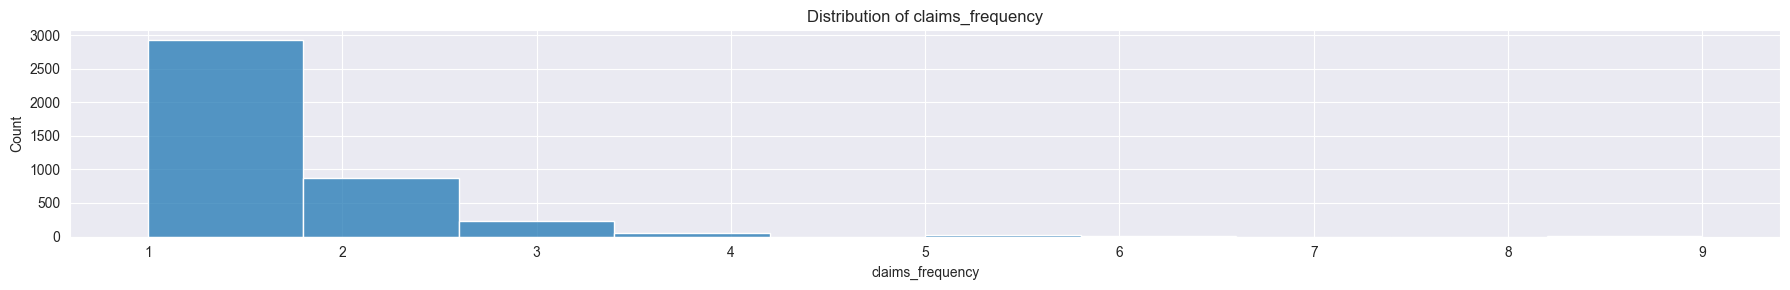

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = ['claims_frequency']
bins = 10
fig, axes = plt.subplots(1, len(cols), figsize=(18, 3))
if len(cols) == 1:
    axes = [axes]
for i, col in enumerate(cols):
    sns.histplot(data=features_trainset, x=col, bins=bins, kde=False, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()

In [5]:
mean_claims_frequency = features_trainset['claims_frequency'].mean()
var_claims_frequency = features_trainset['claims_frequency'].var()
print(f"Mean of claims_frequency: {mean_claims_frequency}")
print(f"Variance of claims_frequency: {var_claims_frequency}")

Mean of claims_frequency: 1.4002918287937742
Variance of claims_frequency: 0.5660714302616024


- From the both the histogram and the mean-variance comparison, we can see that the claims frequency is unimodal and rightly skewed, the mean and variance are not roughly equal (variance is smaller than the mean). This indicates that the data is underdispersed. So lets try to fit a poisson regression model and see how it performs.

In [11]:
features_trainset.columns

Index(['ID', 'Date_birth', 'Date_driving_licence', 'Distribution_channel',
       'Premium', 'Cost_claims_year', 'Type_risk', 'Area', 'Second_driver',
       'Year_matriculation', 'Power', 'Cylinder_capacity', 'Value_vehicle',
       'N_doors', 'Type_fuel', 'Length', 'Weight', 'claims_frequency',
       'Date_birth_dt', 'Date_driving_licence_dt', 'power_to_weight',
       'Car_age_years', 'Driver_age_years', 'Driver_experience_years'],
      dtype='object')

<Axes: title={'center': 'Correlations with Claims Frequency'}>

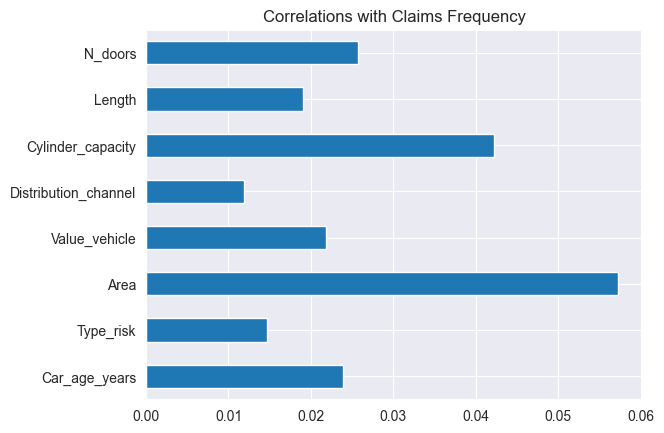

In [20]:
training_variables = ['Car_age_years', 'Type_risk', 'claims_frequency', 'Area', 'Value_vehicle', 'Distribution_channel', 'Cylinder_capacity', 'Length', 'N_doors']
features_trainset[training_variables].corr()['claims_frequency'].drop('claims_frequency').plot(kind='barh', title='Correlations with Claims Frequency')

In [35]:
#Fit the poisson regression model using statsmodel formula api
from statsmodels.formula.api import poisson
poisson_model = poisson('claims_frequency ~ Value_vehicle', data=features_trainset, methods='bfgs')
result_1 = poisson_model.fit()
print(result_1.summary())

         Current function value: 87714087036031927844864.000000
         Iterations: 35
                          Poisson Regression Results                          
Dep. Variable:       claims_frequency   No. Observations:                 4112
Model:                        Poisson   Df Residuals:                     4110
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:              -6.936e+22
Time:                        20:56:24   Log-Likelihood:            -3.6068e+26
converged:                      False   LL-Null:                       -5199.9
Covariance Type:            nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -34.6633   1.11e-11  -3.13e+12      0.000     -34.663     -34.663
Value_vehicle     0.0010   1.16e-1

/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['methods']
  warnings.warn(msg, ValueWarning)
/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['methods']
  warnings.warn(msg, ValueWarning)


In [36]:
 #Fit the poisson model using discrete Generalized Poisson model from statsmodels
from statsmodels.discrete.discrete_model import GeneralizedPoisson
generalised_poisson_model = GeneralizedPoisson(endog=features_trainset['claims_frequency'], exog=features_trainset[['Driver_age_years', 'Driver_experience_years', 'Car_age_years', 'power_to_weight', 'Type_risk']], p=2).fit(method='nm')
print(generalised_poisson_model.summary())

/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                    GeneralizedPoisson Regression Results                     
Dep. Variable:       claims_frequency   No. Observations:                84444
Model:             GeneralizedPoisson   Df Residuals:                    84439
Method:                           MLE   Df Model:                            4
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                     nan
Time:                        21:04:40   Log-Likelihood:                    nan
converged:                      False   LL-Null:                           nan
Covariance Type:            nonrobust   LLR p-value:                       nan
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Driver_age_years               nan        nan        nan        nan         nan         nan
Driver_experience_years        nan        nan        nan        nan         nan         nan


/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [30]:
#TODO: interpret the model results and look into evaluation metrics
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Generate predictions on the test set
y_pred = result_1.predict(features_testset)
y_true = features_testset['claims_frequency'].fillna(0)

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# Display results
print("Poisson Model Evaluation on Test Set:")
print("=" * 40)
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Square Error): {rmse:.4f}")
print(f"R² (R-squared): {r2:.4f}")

/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:1074: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


ValueError: Input contains NaN.